In [10]:
import json, torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.sparse import csr_matrix

In [11]:
# Read in the JSON data
data_stream = ""
with open("challenge_set.json", "r") as f:
    data_stream = f.read()
data_set = json.loads(data_stream)


# Grab unique track/artist pairs
track_uris = set()
playlist_idcs = []

for i,j in enumerate(data_set["playlists"]):
    if len(j["tracks"]) == 100:
        playlist_idcs.append(i) 
        for track in j["tracks"]:
            track_uris.add((track["track_name"], track["artist_name"], track["track_uri"]))
unique_tracks = list(track_uris)

# Define mapping between URIs and trakcs
uri_to_title_artist_map = {x[2]: (x[0], x[1]) for x in unique_tracks}
for i,(j,k) in enumerate(uri_to_title_artist_map.items()):
    if i > 20: break
    print(j,k)

spotify:track:0cZS0qVwDadhqzmrDd2QUe ('Push', 'Enrique Iglesias')
spotify:track:70OrTBlb0RLKNfxWE6fZZM ('Let It Be Christmas', 'Alan Jackson')
spotify:track:30yMeJ0TDEiMWMRBuWVQah ('Ivo', 'Maxence Cyrin')
spotify:track:0sQ3DlfuQZozaOnAS1r4yG ('Porn Star Dancing - Bonus Track', 'My Darkest Days')
spotify:track:73pbvYLtPlT6frmLHAmPV8 ('Covered N Money', 'Future')
spotify:track:65N2jXm9IZeSLaGM6G65YE ('Three Empty Words', 'Shawn Mendes')
spotify:track:1JrxRBUBjTwGPvuuUVEc5E ('All Our Lives', 'Andrew McMahon in the Wilderness')
spotify:track:6YRZngBVAy2FgUQWk3lwL1 ('Lyrics to Go', 'A Tribe Called Quest')
spotify:track:0zstgBrV1t1g6n4jHrUVBY ('Gaston - From "Beauty and the Beast" / Soundtrack Version', 'Richard White')
spotify:track:3cDE9Yn4GrsxSrlMCLdmTT ('Love Like Winter', 'AFI')
spotify:track:6qL8tweXFMqztcMwNB4r7y ('Something Kinda Funny', 'Spice Girls')
spotify:track:193ZaXTaD0dPz66pUYS3SQ ('Pink Rabbits', 'The National')
spotify:track:5s9sZ2i76iAZeFt5f9uUKP ('Lightning Bolt', 'Jake B

In [23]:
# Rearranging data table
df = pd.read_csv("all_downloaded_data.csv")
df = df.drop("Unnamed: 0", axis=1)
df = df.set_index('uri')
# df = df.iloc[:, :11]
df = df.drop_duplicates()

print(df.head())

                                      danceability  energy  key  loudness  \
uri                                                                         
spotify:track:38uqMByifM0mkjcTbejlyR         0.375   0.294    8    -8.751   
spotify:track:4kOTDj4SiZPkW1p96WMDNv         0.950   0.803    1    -4.195   
spotify:track:1c9LBfX0klXJscJAYDI0Ea         0.758   0.501    0    -7.051   
spotify:track:59iNA6gwthoTJ6IgpBGGHW         0.534   0.749    6    -5.562   
spotify:track:4QCng4MDyUhEZ730Ma2Rjp         0.674   0.744   11    -5.196   

                                      mode  speechiness  acousticness  \
uri                                                                     
spotify:track:38uqMByifM0mkjcTbejlyR     1       0.0329        0.9280   
spotify:track:4kOTDj4SiZPkW1p96WMDNv     1       0.1510        0.1450   
spotify:track:1c9LBfX0klXJscJAYDI0Ea     1       0.0589        0.2520   
spotify:track:59iNA6gwthoTJ6IgpBGGHW     0       0.0749        0.0776   
spotify:track:4QCng4MD

Example of uri_to_title_artist_map usage and characterize dataset

In [13]:
# Validate map use
uri_to_title_artist_map["spotify:track:38uqMByifM0mkjcTbejlyR"]

# Demonstrate data size
print(len(unique_tracks))
print(len(playlist_idcs), "total playlists")
print(df.shape[0], "total songs")

53552
2000 total playlists
53550 total songs


Defining playlist membership relationships for tracks

In [14]:
membership_mtx = np.load("playlist_membership_data.npy")
membership_lbls = np.load("playlist_membership_labels.npy")
print("Avg song is in", np.mean(np.sum(membership_mtx, axis=1)), "playlists")

# Remove mostercat songs that don't exist.
filtered_mtx = membership_mtx
filtered_lbls = membership_lbls
for idx, i in enumerate(filtered_lbls):
    if i[2] == "spotify:track:5CmMyiq4um2aFhiLZ1rPWo":
        filtered_mtx = np.delete(filtered_mtx, idx, axis=0)
        filtered_lbls = np.delete(filtered_lbls, idx, axis=0)
        
for idx, i in enumerate(filtered_lbls):
    if i[2] == "spotify:track:4mjgNE8R31AzxWfPNGtVMf":
        filtered_mtx = np.delete(filtered_mtx, idx, axis=0)
        filtered_lbls = np.delete(filtered_lbls, idx, axis=0)

Avg song is in 3.695492231849417 playlists


In [15]:
# This is a super sparse matrix, so use csr format to save space.
test = csr_matrix(filtered_mtx)
frequency_csr_mtx = test @ test.T
print(test.shape)
print(frequency_csr_mtx.shape)

dense_data = frequency_csr_mtx.todense()
print(dense_data.shape)

(53550, 2000)
(53550, 53550)
(53550, 53550)


In [ ]:
def 

In [25]:
# Create Dev and Test Data
data_size = dense_data.shape[0]
test_dev_idcs = np.random.choice(data_size, replace=False, size=int(0.3*data_size))

# Select indices of test/dev indices of filtered data to be used for dev
dev_idcs = np.random.choice(test_dev_idcs.shape[0], replace=False, size=int((2/3) * test_dev_idcs.shape[0]))
selected_dev_labels = filtered_lbls[test_dev_idcs[dev_idcs]]
dev_data = df.loc[selected_dev_labels[:, 2]]
dev_data = dev_data.iloc[:, 0:11].to_numpy()
dev_labels = np.array(np.max(dense_data[dev_idcs], axis=1).T)[0]
print("dev")
print(dev_data.shape)
print(dev_labels.shape)

# Delete dev indices from test/dev indices of filtered data to keep test indices of filtered data
test_idcs = np.delete(test_dev_idcs, dev_idcs, axis=0)
selected_test_labels = filtered_lbls[test_idcs]
test_data = df.loc[selected_test_labels[:, 2]]
test_data = test_data.iloc[:, 0:11].to_numpy()
test_labels = np.array(np.max(dense_data[test_idcs], axis=1).T)[0]
print("test")
print(test_data.shape)
print(test_labels.shape)

# Create Training Data
train_idcs = np.delete(np.arange(df.shape[0]), test_dev_idcs, axis=0)
selected_train_lbls = np.delete(filtered_lbls, test_dev_idcs, axis=0)
train_data = df.loc[selected_train_lbls[:,2]]
train_data = train_data.iloc[:, 0:11].to_numpy()
train_labels = np.array(np.max(np.delete(dense_data, test_dev_idcs, axis=0), axis=1).T)[0]
print("train")
print(train_data.shape)
print(train_labels.shape)

dev
(10710, 11)
(10710,)
[32596  8665 25344 ... 51327 11786 31505]
[ 9127 18429 24424 ... 22636 34203  5383]
[12928  3612  7958 ... 14448  5149  5734]
[32596 25344 18939 ... 10141 10402 22840]
test
(5355, 10)
(5355,)
train
(37485, 10)
(37485,)


In [17]:
def normalize(data):
    col_means = data.mean(axis=0)
    col_std = data.std(axis=0)
    return (data - col_means) / col_std

train_data = normalize(train_data)
dev_data = normalize(dev_data)
test_data = normalize(test_data)

In [18]:
lr = 0.01
batch_size = 100
epochs = 100

In [19]:
class RecommenderNet(torch.nn.Module):
    ### Implement your model's structure and input/filter/output dimensions
    def __init__(self, num_songs):
        super().__init__()
        self.lm1 = torch.nn.Linear(10, 1000)
#         self.lm2 = torch.nn.Linear(100, 1000)
        self.lm3 = torch.nn.Linear(1000, num_songs)
        
        self.num_songs = num_songs

    def forward(self, x):
        x = torch.tanh(self.lm1(x))
#         x = torch.tanh(self.lm2(x))
        x = self.lm3(x)
        return x

In [20]:
number_of_songs = df.shape[0] 

model = RecommenderNet(number_of_songs)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_steps = []
train_losses = []
dev_steps = []
dev_losses = []

for step in range(epochs):
    i = np.random.choice(train_data.shape[0], size=batch_size, replace=False)
    x = torch.from_numpy(train_data[i].astype(np.float32))
    y = torch.from_numpy(train_labels[i].astype(np.float32))
    idcs = train_idcs[i]
    
    prediction_idcs = model(x)
    pred_freq = np.array(dense_data[idcs, prediction_idcs.argmax(axis=1)])[0]
    test = torch.from_numpy(pred_freq.astype(np.float32))
    test.requires_grad = True
    loss = F.mse_loss(test, y) 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_steps.append(step)
    train_losses.append(loss.item())
    
    if step % 10 == 0:
        dev_i = np.random.choice(dev_data.shape[0], size=5000, replace=False)
        dev_d = torch.from_numpy(dev_data[dev_i].astype(np.float32))
        dev_l = torch.from_numpy(dev_labels[dev_i].astype(np.float32))
        dev_idc = dev_idcs[dev_i]
        
        dev_pred = model(dev_d)
        pred_freq = np.array(dense_data[dev_idc, dev_pred.argmax(axis=1)])[0]
        dev = torch.from_numpy(pred_freq.astype(np.float32))
        dev_loss = F.mse_loss(dev, dev_l)
        
        dev_steps.append(step)
        dev_losses.append(dev_loss.item())
        
        print(f"{(step/epochs) * 100:0.1f}% {loss.item()}, {dev_loss.item()}")
    

0.0% 192.42999267578125, 83.49099731445312
10.0% 52.08000183105469, 93.8583984375
20.0% 81.86000061035156, 91.74459838867188
30.0% 70.5999984741211, 85.57959747314453
40.0% 61.77000045776367, 82.99739837646484
50.0% 58.45000076293945, 81.59400177001953
60.0% 66.7300033569336, 93.75360107421875
70.0% 17.889999389648438, 81.7656021118164
80.0% 138.27999877929688, 83.3781967163086
90.0% 89.5999984741211, 88.28759765625


Text(0.5, 0, 'step')

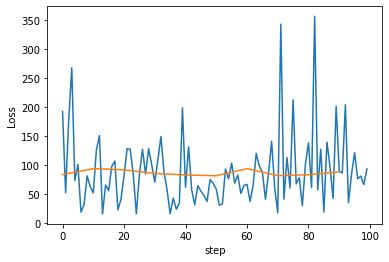

In [21]:
plt.plot(train_steps, train_losses)
plt.plot(dev_steps, dev_losses)
plt.ylabel("Loss")
plt.xlabel("step")